In [1]:
#imports
import pandas as pd
import os
import numpy as np
import math
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms,models
from torchvision.io import read_image
import torch.nn.functional as F 
from torchvision.utils import make_grid
from torch.optim import lr_scheduler
#from torchvision.ops import stochastic_depth

import timm
from timm.loss import LabelSmoothingCrossEntropy

print(torch.__version__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


2.1.2
cuda:0


# **Loading the dataset**

In [2]:
path = "/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2"


data = {"imagepath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imagepath"].append(fpath)
        data["labels"].append(folder)
        
    df = pd.DataFrame(data) 

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])


print("-------------Fetch files into a data frame-----------")
print(df)
print("-------------Path to an image file------------------")
print(df.loc[175]['imagepath']) 
print("-----------Number of images per category--------------")
print(df.labels.value_counts())  

-------------Fetch files into a data frame-----------
                                              imagepath labels  encoded_labels
0     /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...   Zain              30
1     /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...   Zain              30
2     /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...   Zain              30
3     /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...   Zain              30
4     /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...   Zain              30
...                                                 ...    ...             ...
6980  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Laa              13
6981  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Laa              13
6982  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Laa              13
6983  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Laa              13
6984  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Laa              1

# **Displaying Histogram of the dataset**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


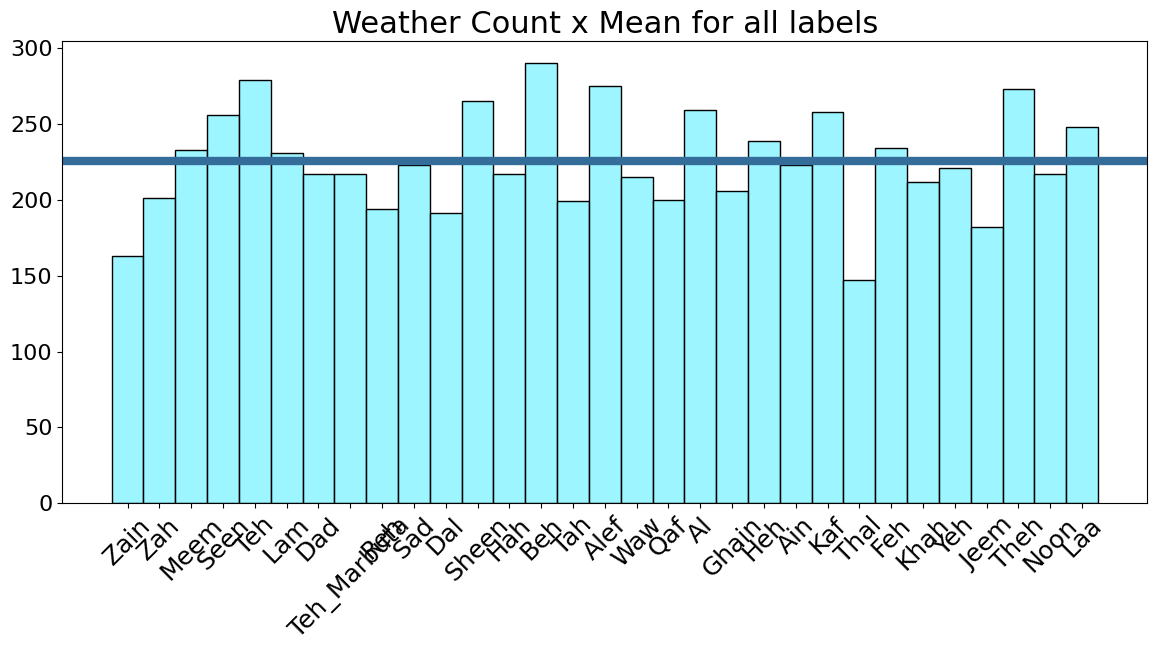

In [3]:
ax = sns.histplot(data=df, x="labels", color="#7df2ff")
ax.figure.set_size_inches(14, 6)
plt.axhline(y=df.groupby("labels").count().mean().mean(), lw=6, color="#346c9a")
plt.xticks(rotation=45, font="Verdana", fontsize=18)
plt.yticks(font="Verdana", fontsize=16)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("Weather Count x Mean for all labels", font="Verdana", fontsize=22)

plt.show()

# **Splitting into train,val and test sets** 

In [4]:
train_df, temp_df = train_test_split(df,  train_size= 0.70 , shuffle=True, random_state=124, stratify = df.labels)
valid_df , test_df = train_test_split(temp_df ,  train_size= 0.70 , shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("----------Train-------------")
print(train_df[["imagepath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imagepath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imagepath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                           imagepath labels
0  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Ain
1  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Tah
2  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Sad
3  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...   Jeem
4  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Dad
(4889, 3)
--------Validation----------
                                           imagepath labels
0  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Laa
1  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...   Khah
2  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...   Khah
3  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...   Seen
4  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...    Lam
(1467, 3)
----------Test--------------
                                           imagepath labels
0  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba...     Al
1  /kaggle/input/arsl-no-background-v2/ARSL-No-Ba... 

# **Displaying random images**

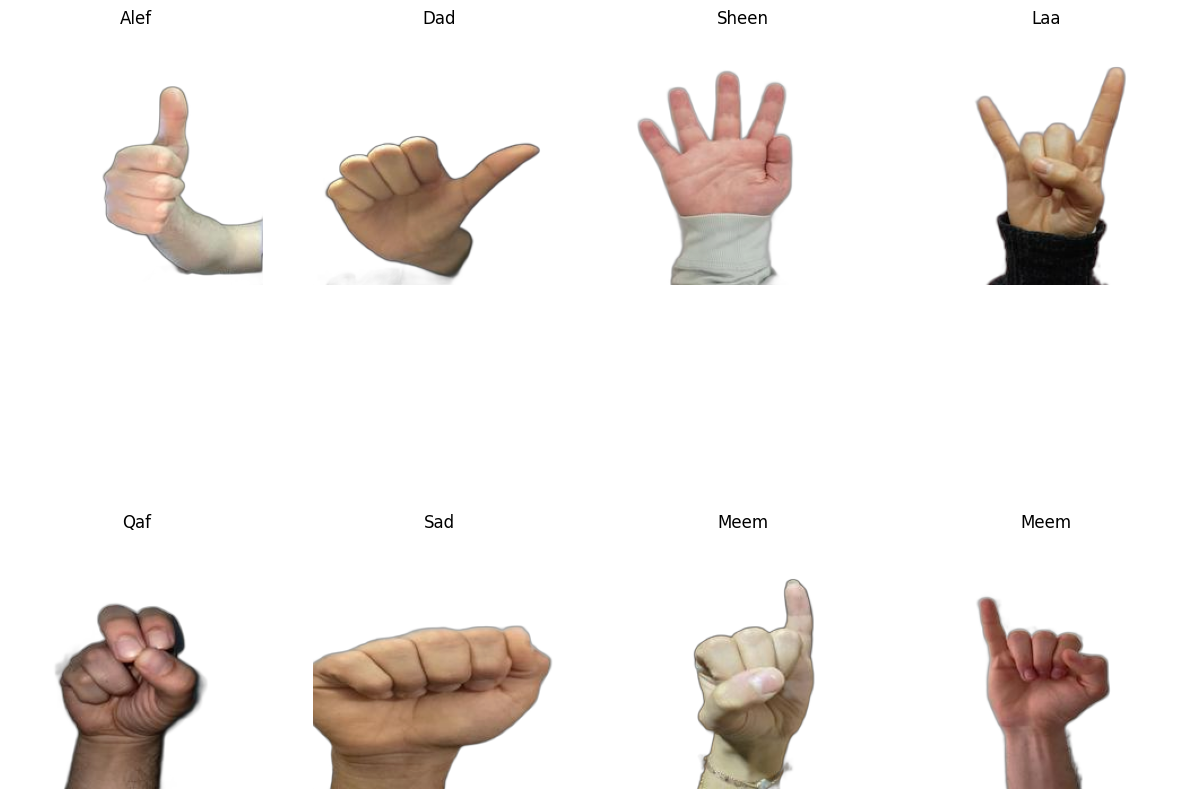

In [5]:
plt.figure(figsize=(15,12))
for i, row in test_df.sample(n=8).reset_index().iterrows():
    plt.subplot(2,4,i+1)
    image_path = row['imagepath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

# **Data Augmentation**

In [6]:

train_transforms = transforms.Compose([
    #transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=15),
    #transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# **Displaying random sample and the augmented image**

In [7]:
#Load & View Random Sample Image
def load(imagepath, as_tensor=True):
    # Read and decode an image file to a uint8 tensor
    image = Image.open(imagepath).convert('RGB')
    
    if as_tensor:
        converter = transforms.ToTensor()
        return converter(image)
    else:
        return image


def view_sample(image, label, color_map='rgb', fig_size=(8, 10)):
    plt.figure(figsize=fig_size)
    
    if color_map=='rgb':
        plt.imshow(image)
    else:
        plt.imshow(image, cmap=color_map)
    
    plt.title(f'Label: {label}', fontsize=16)
    return

In [8]:
# Select random sample from df
import random
idx = random.sample(df.index.to_list(), 1)[0]

# Load the random sample and label
aug_image = load(df.imagepath[idx], as_tensor=False)

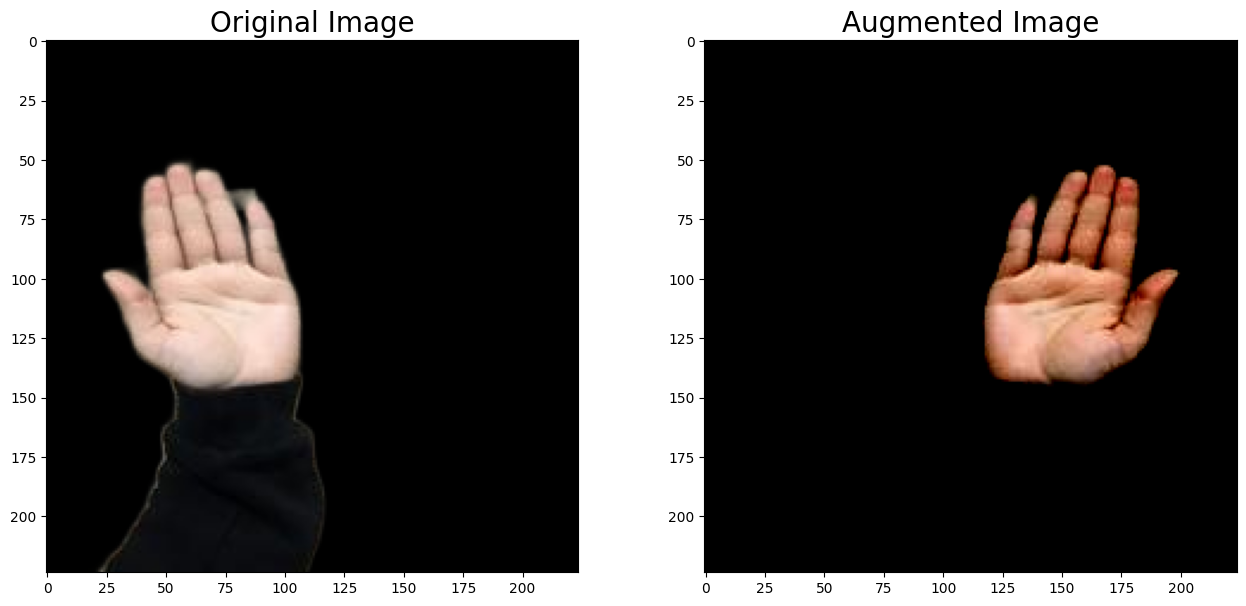

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# View Original Image
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(aug_image);

# View Augmented Image
ax2.set_title('Augmented Image', fontsize=20)
ax2.imshow(train_transforms(aug_image).permute(1, 2, 0));

# **Building datasets based on splits**

In [10]:
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple

In [11]:
class ArSL_Dataset(Dataset):
    def __init__(self, df:pd.DataFrame, transform=None) -> None:
        super().__init__()
        
        self.paths = df['imagepath'].to_list()
        self.labels = df['labels'].to_list()
        self.transform = transform
        
        self.classes = sorted(list(df['labels'].unique()))
        self.class_to_idx = {cls_name: _ for _, cls_name in enumerate(self.classes)}
        
    def load_image(self, index:int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path).convert('RGB')  
        
    def __len__(self) -> int:
        return self.paths.__len__()
    
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        image = self.load_image(index)
        class_name = self.labels[index]
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(image), class_idx
        else:
            return image, class_idx

In [12]:
# Build train dataset
train_ds = ArSL_Dataset(train_df, transform=train_transforms)

# Build validation dataset
valid_ds = ArSL_Dataset(valid_df, transform=test_transforms)

# Build test dataset
test_ds = ArSL_Dataset(test_df, transform=test_transforms)

In [13]:
BATCH_SIZE = (
        32 if torch.cuda.device_count() < 2 
        else (32 * torch.cuda.device_count())
    )
train_dataloader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_ds, batch_size = BATCH_SIZE, shuffle= False)
test_dataloader = DataLoader(test_ds, batch_size= BATCH_SIZE , shuffle=False)

print(">> Number of Train Data : {} -- Batch Size : {} -- Number of Batch : {} ".format(len(train_dataloader.dataset) , BATCH_SIZE , len(train_dataloader)))
print(">> Number of Valid Data : {} -- Batch Size : {} -- Number of Batch : {} ".format(len(valid_dataloader.dataset) , BATCH_SIZE , len(valid_dataloader)))
print(">> Number of  Test Data : {} -- Batch Size : {} -- Number of Batch : {} ".format(len(test_dataloader.dataset) , BATCH_SIZE , len(test_dataloader)))
onebatch = iter(train_dataloader)
train_features, train_labels = next(onebatch)
print("----------Batch Shape--------")
print(f"Feature batch shape: {train_features.size()}")
print("----------Labels Shape--------")
print(f"Labels batch shape: {train_labels.size()}")

>> Number of Train Data : 4889 -- Batch Size : 64 -- Number of Batch : 77 
>> Number of Valid Data : 1467 -- Batch Size : 64 -- Number of Batch : 23 
>> Number of  Test Data : 629 -- Batch Size : 64 -- Number of Batch : 10 
----------Batch Shape--------
Feature batch shape: torch.Size([64, 3, 224, 224])
----------Labels Shape--------
Labels batch shape: torch.Size([64])


# **KANLinear**

In [14]:
# Define the KANLinear class as provided
class KANLinear(nn.Module):
    def __init__(self, in_features, out_features, grid_size=10, spline_order=3, scale_noise=0.05, scale_base=0.5, scale_spline=0.5, enable_standalone_scale_spline=True, base_activation=nn.SiLU, grid_eps=0.02, grid_range=[-1, 1]):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = ((torch.arange(-spline_order, grid_size + spline_order + 1) * h + grid_range[0]).expand(in_features, -1).contiguous())
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order))
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(torch.Tensor(out_features, in_features))

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = ((torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 1 / 2) * self.scale_noise / self.grid_size)
            self.spline_weight.data.copy_((self.scale_spline if not self.enable_standalone_scale_spline else 1.0) * self.curve2coeff(self.grid.T[self.spline_order : -self.spline_order], noise))
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        grid = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - grid[:, : -(k + 1)]) / (grid[:, k:-1] - grid[:, : -(k + 1)]) * bases[:, :, :-1]) + ((grid[:, k + 1 :] - x) / (grid[:, k + 1 :] - grid[:, 1:(-k)]) * bases[:, :, 1:])
        assert bases.size() == (x.size(0), self.in_features, self.grid_size + self.spline_order)
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)
        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        result = solution.permute(2, 0, 1)
        assert result.size() == (self.out_features, self.in_features, self.grid_size + self.spline_order)
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (self.spline_scaler.unsqueeze(-1) if self.enable_standalone_scale_spline else 1.0)

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(self.b_splines(x).view(x.size(0), -1), self.scaled_spline_weight.view(self.out_features, -1))
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)
        splines = self.b_splines(x).permute(1, 0, 2)
        orig_coeff = self.scaled_spline_weight.permute(1, 2, 0)
        unreduced_spline_output = torch.bmm(splines, orig_coeff).permute(1, 0, 2)
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[torch.linspace(0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device)]
        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (torch.arange(self.grid_size + 1, dtype=torch.float32, device=x.device).unsqueeze(1) * uniform_step + x_sorted[0] - margin)
        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.cat([grid[:1] - uniform_step * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1), grid, grid[-1:] + uniform_step * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1)], dim=0)
        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return regularize_activation * regularization_loss_activation + regularize_entropy * regularization_loss_entropy
     

# **Model Architecture**

In [15]:
class CustomEfficientNetKAN(nn.Module):
    def __init__(self, num_classes=31):
        super(CustomEfficientNetKAN, self).__init__()
        # Load pretrained EfficientNet model
        self.model = timm.create_model('efficientnet_b3', pretrained=True)
        # Replace the classifier layer with KANLinear
        self.model.classifier = KANLinear(self.model.classifier.in_features, out_features=num_classes)

    def forward(self, x):
        return self.model(x)
        

In [16]:
#model = resnext50(num_classes = 31)
#model = model.to(device)
model = CustomEfficientNetKAN().to(device)

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

# **Hyperparameters**

In [17]:
# Define Loss Function
loss_fn = LabelSmoothingCrossEntropy()

# Define Optimizer
optimizer = optim.Adam(model.parameters(),lr= 0.001)

In [18]:
#Define Scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [19]:
from torch.cuda.amp import GradScaler, autocast
# Initialize GradScaler
scaler = GradScaler()

# **Train Function**

In [20]:
def execute_epoch(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    device: torch.device,
    scaler: GradScaler
) -> Tuple[float, float]:
    # Set model into training mode
    model.train()

    # Initialize train loss & accuracy
    train_loss, train_acc = 0, 0


    # Execute training loop over train dataloader
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        # Load data onto target device
        X, y = X.to(device), y.to(device)

        # Enable autocast for mixed precision
        with autocast():
            # Forward pass and compute loss
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()

        # Reset gradients & backpropagate loss using scaler
        optimizer.zero_grad()
        scaler.scale(loss).backward()

        # Update model gradients using scaler
        scaler.step(optimizer)
        scaler.update()

        # Compute batch metrics
        predicted_class = torch.argmax(
            torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (predicted_class == y).sum().item() / len(y_pred)

    # Compute step metrics
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

# **Evaluation Function**

In [21]:
def evaluate(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    # Set model into eval mode
    model.eval()
    
    # Initialize eval loss & accuracy
    eval_loss, eval_acc = 0, 0
    
    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(dataloader):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward and compute metrics
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            eval_loss += loss.item() 

            # Compute Batch Metrics
            predicted_class = torch.argmax(
                torch.softmax(y_pred, dim=1), dim=1)
            eval_acc += (predicted_class == y).sum().item() / len(y_pred)
        
    # Compute Step Metrics
    eval_loss = eval_loss / len(dataloader)
    eval_acc = eval_acc / len(dataloader)
    
    return eval_loss, eval_acc

In [22]:
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    eval_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device,
    scheduler: lr_scheduler._LRScheduler,  # Learning rate scheduler
    save_weights_path: str = "best_weights(EfficientNet).pth",  # Path to save the best weights
    save_model_path: str = "best_model(EfficientNet).pth",  # Path to save the best model
    patience: int = 5  # Patience counter for early stopping
) -> Dict[str, List]:
    
    # Initialize training session
    session = {
        'loss': [],
        'accuracy': [],
        'eval_loss': [],
        'eval_accuracy': []
    }
    
    best_eval_acc = 0  # Track the best evaluation accuracy
    patience_counter = 0  # Initialize patience counter
    
    # Initialize GradScaler
    #scaler = GradScaler()
    
    # Training loop
    for epoch in tqdm(range(epochs)):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        
        # Execute Epoch with mixed precision
        train_loss, train_acc = execute_epoch(
            model, 
            train_dataloader, 
            optimizer, 
            loss_fn, 
            device,
            scaler  # Pass GradScaler to execute_epoch
        )
        
        # Evaluate Model
        eval_loss, eval_acc = evaluate(
            model, 
            eval_dataloader, 
            loss_fn, 
            device
        )
        
        # Log Epoch Metrics
        print(f'loss: {train_loss:.4f} - acc: {train_acc:.4f} - eval_loss: {eval_loss:.4f} - eval_acc: {eval_acc:.4f}')
        print(f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')  # Log the current learning rate
        
        # Record Epoch Metrics
        session['loss'].append(train_loss)
        session['accuracy'].append(train_acc)
        session['eval_loss'].append(eval_loss)
        session['eval_accuracy'].append(eval_acc)
        
        # Save the best weights and model if evaluation accuracy improves
        if eval_acc > best_eval_acc:
            best_eval_acc = eval_acc
            # Save the best weights
            torch.save(model.state_dict(), save_weights_path)
            # Save the best model
            torch.save(model, save_model_path)
            print(f"Best model saved with eval accuracy: {best_eval_acc:.4f}")
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1  # Increment patience counter
        
        # Update the learning rate scheduler
        scheduler.step()
        
        # Early stopping condition based on patience
        if patience_counter >= patience:
            print(f"Early stopping triggered! No improvement for {patience} epochs.")
            break
        
        # Early stopping condition based on high accuracy
       # if train_acc >= 0.99 and eval_acc >= 0.98:
            #print("Early stopping triggered! High accuracy achieved.")
            #break
    
    return session

In [23]:
# Train the model 
print(f'Train on {len(train_df)} samples, validate on {len(valid_df)} samples.')
print('----------------------------------')

session_config = {
    'model'               : model,
    'train_dataloader'    : train_dataloader,
    'eval_dataloader'     : valid_dataloader,
    'optimizer'           : optimizer,
    'loss_fn'             : loss_fn,
    'epochs'              : 50,
    'device'              : device,
    'scheduler'           : scheduler,
}

session_history = train(**session_config)

Train on 4889 samples, validate on 1467 samples.
----------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 1.3120 - acc: 0.7842 - eval_loss: 0.8292 - eval_acc: 0.9503
Learning Rate: 0.001000
Best model saved with eval accuracy: 0.9503

Epoch 2/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.7944 - acc: 0.9593 - eval_loss: 0.7798 - eval_acc: 0.9605
Learning Rate: 0.001000
Best model saved with eval accuracy: 0.9605

Epoch 3/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.7405 - acc: 0.9754 - eval_loss: 0.7409 - eval_acc: 0.9734
Learning Rate: 0.001000
Best model saved with eval accuracy: 0.9734

Epoch 4/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.7183 - acc: 0.9805 - eval_loss: 0.7646 - eval_acc: 0.9646
Learning Rate: 0.001000

Epoch 5/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.7324 - acc: 0.9767 - eval_loss: 0.7187 - eval_acc: 0.9762
Learning Rate: 0.001000
Best model saved with eval accuracy: 0.9762

Epoch 6/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.6955 - acc: 0.9860 - eval_loss: 0.7257 - eval_acc: 0.9768
Learning Rate: 0.001000
Best model saved with eval accuracy: 0.9768

Epoch 7/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.7112 - acc: 0.9832 - eval_loss: 0.7018 - eval_acc: 0.9844
Learning Rate: 0.001000
Best model saved with eval accuracy: 0.9844

Epoch 8/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.6692 - acc: 0.9957 - eval_loss: 0.6830 - eval_acc: 0.9891
Learning Rate: 0.000100
Best model saved with eval accuracy: 0.9891

Epoch 9/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.6609 - acc: 0.9978 - eval_loss: 0.6790 - eval_acc: 0.9891
Learning Rate: 0.000100

Epoch 10/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.6595 - acc: 0.9977 - eval_loss: 0.6787 - eval_acc: 0.9905
Learning Rate: 0.000100
Best model saved with eval accuracy: 0.9905

Epoch 11/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.6562 - acc: 0.9992 - eval_loss: 0.6789 - eval_acc: 0.9891
Learning Rate: 0.000100

Epoch 12/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.6548 - acc: 0.9992 - eval_loss: 0.6757 - eval_acc: 0.9891
Learning Rate: 0.000100

Epoch 13/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.6559 - acc: 0.9988 - eval_loss: 0.6758 - eval_acc: 0.9898
Learning Rate: 0.000100

Epoch 14/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.6543 - acc: 0.9990 - eval_loss: 0.6756 - eval_acc: 0.9885
Learning Rate: 0.000100

Epoch 15/50


  0%|          | 0/77 [00:00<?, ?it/s]

loss: 0.6532 - acc: 0.9994 - eval_loss: 0.6738 - eval_acc: 0.9898
Learning Rate: 0.000010
Early stopping triggered! No improvement for 5 epochs.


In [24]:
# lr scheduler
#exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

# **Inference**

In [25]:
def predict(
    model:nn.Module, 
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device) -> np.ndarray:
    
    # Set model into eval mode
    model.eval()
    
    predictions = []
    
    # Active inference context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(tqdm(sample_loader)):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward and compute metrics
            y_pred = model(X) 

            # Compute Batch Metrics
            predicted_probs = torch.softmax(y_pred, dim=1).cpu().numpy()
            
            # Record prediction
            predictions.append(predicted_probs)
        
    return np.vstack(predictions)

In [26]:
# Generate test sample probabilities 
test_probs = predict(model, test_dataloader, device)

  0%|          | 0/10 [00:00<?, ?it/s]

In [27]:
# Generate test sample preditions 
test_preds = np.argmax(test_probs, axis=1)

# **Plot Model Performance**

In [28]:
def plot_training_curves(history):
    
    loss = np.array(history['loss'])
    val_loss = np.array(history['eval_loss'])

    accuracy = np.array(history['accuracy'])
    val_accuracy = np.array(history['eval_accuracy'])

    epochs = range(len(history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='eval_loss', marker='o')
    
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='validation_accuracy', marker='o')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();
    
    sns.despine();
    
    return

In [29]:
session_history_df = pd.DataFrame(session_history)
session_history_df

,loss,accuracy,eval_loss,eval_accuracy
0,1.311999,0.784245,0.829240,0.950292
1,0.794433,0.959302,0.779833,0.960540
2,0.740540,0.975446,0.740886,0.973448
3,0.718250,0.980495,0.764564,0.964559
4,0.732424,0.976664,0.718738,0.976223
5,0.695531,0.985974,0.725707,0.976845
6,0.711200,0.983157,0.701787,0.984375
7,0.669243,0.995739,0.683000,0.989130
8,0.660887,0.997768,0.678994,0.989130
9,0.659465,0.997654,0.678682,0.990489


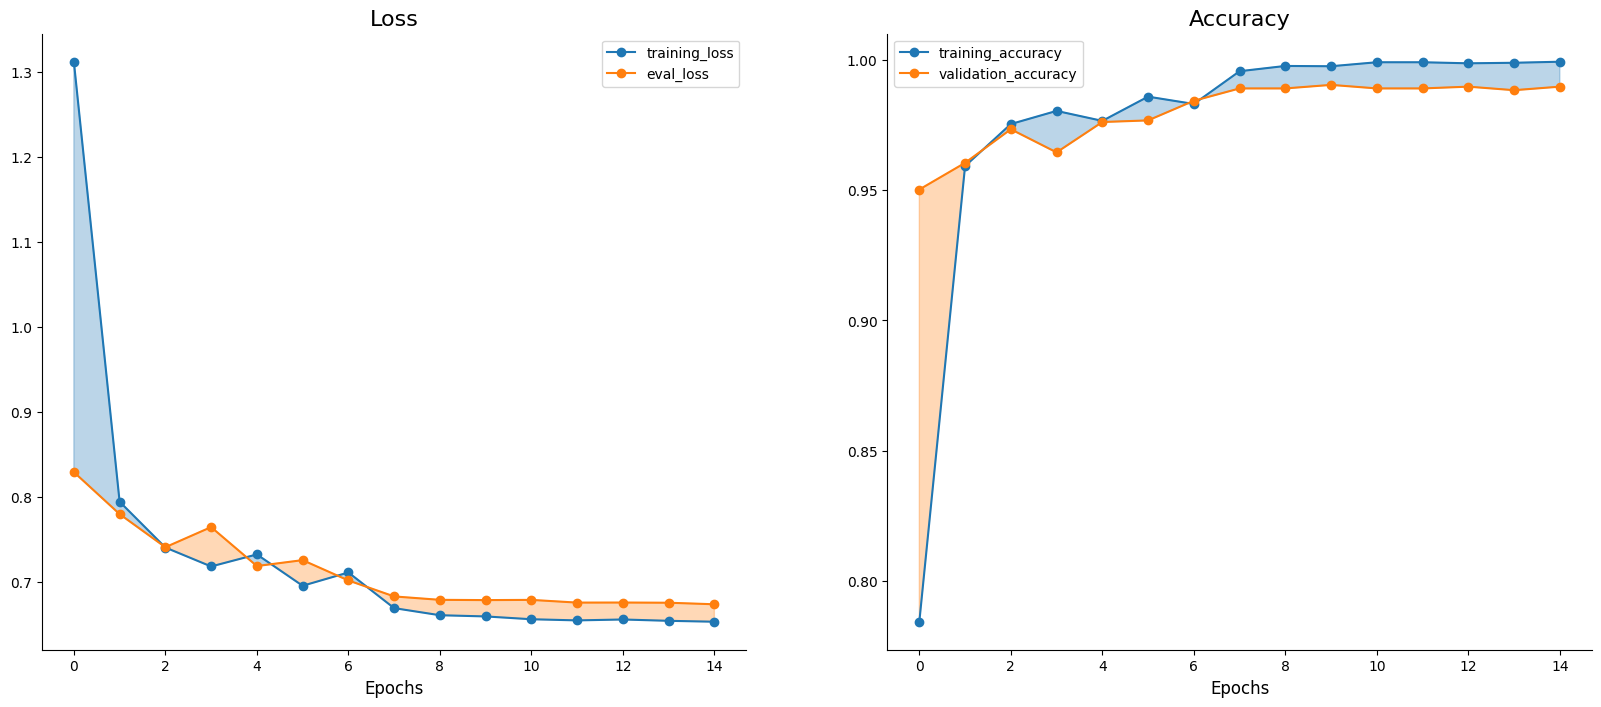

In [30]:
plot_training_curves(session_history)

# **Performance Metrics**

In [31]:
#imports
from scikitplot.metrics import plot_roc
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support,
    accuracy_score, top_k_accuracy_score, f1_score, 
    matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
)

**Confusion Matrix**

In [32]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12): 
    # Generate confusion matrix 
    cm = confusion_matrix(y_true, y_pred)
    
    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=0.5, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)
    
    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20) 
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0) 

    # Plot confusion matrix
    plt.show()
    
    return

In [33]:
#mapping
test_labels = [*map(test_ds.class_to_idx.get, test_ds.labels)]

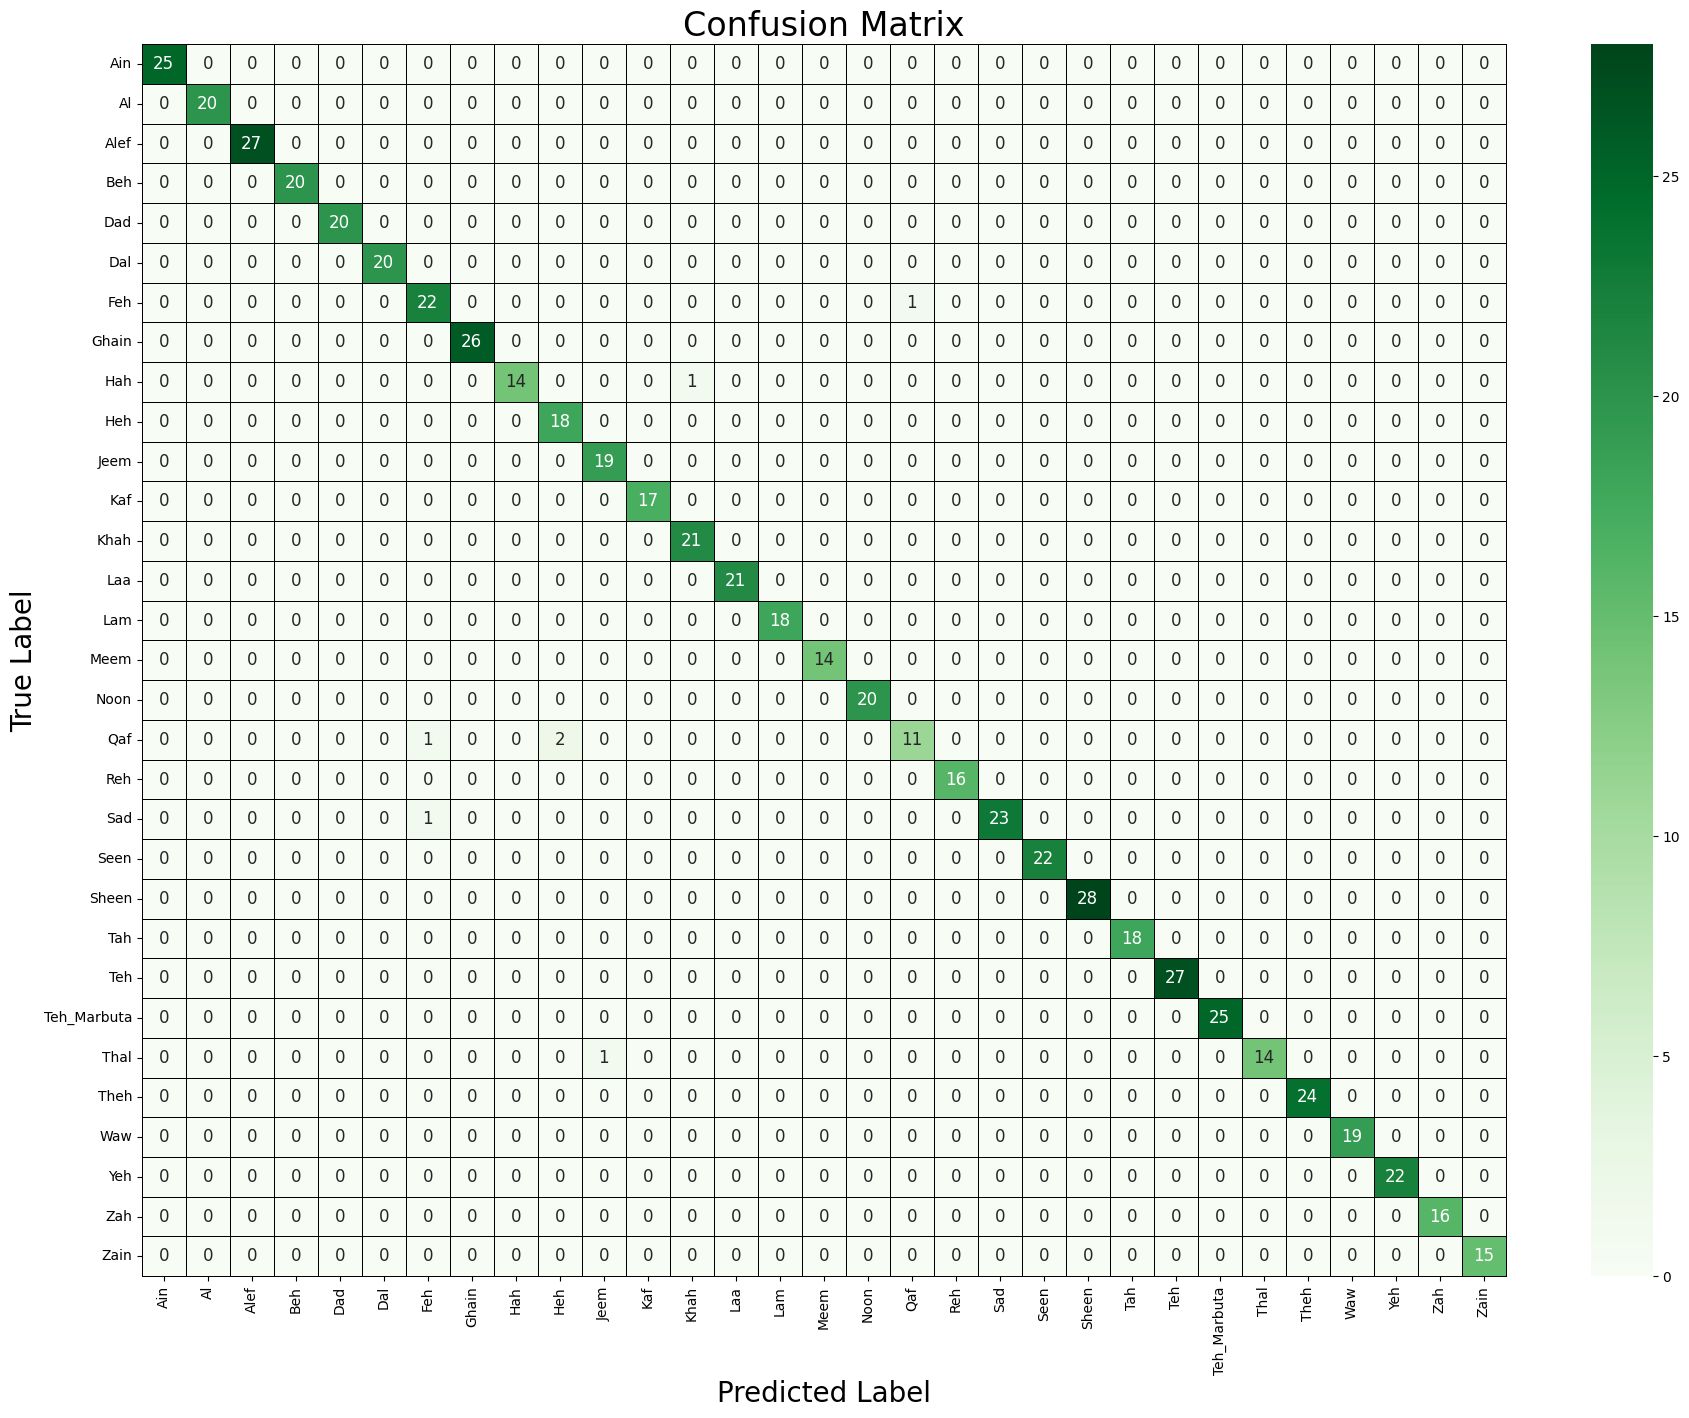

In [34]:
plot_confusion_matrix(
    test_labels, 
    test_preds, 
    figsize=(22, 16),  
    classes=test_ds.classes)

**Classification Report**

In [35]:
print(
    classification_report(
        test_labels, 
        test_preds, 
        target_names=test_ds.classes
    )
)

              precision    recall  f1-score   support

         Ain       1.00      1.00      1.00        25
          Al       1.00      1.00      1.00        20
        Alef       1.00      1.00      1.00        27
         Beh       1.00      1.00      1.00        20
         Dad       1.00      1.00      1.00        20
         Dal       1.00      1.00      1.00        20
         Feh       0.92      0.96      0.94        23
       Ghain       1.00      1.00      1.00        26
         Hah       1.00      0.93      0.97        15
         Heh       0.90      1.00      0.95        18
        Jeem       0.95      1.00      0.97        19
         Kaf       1.00      1.00      1.00        17
        Khah       0.95      1.00      0.98        21
         Laa       1.00      1.00      1.00        21
         Lam       1.00      1.00      1.00        18
        Meem       1.00      1.00      1.00        14
        Noon       1.00      1.00      1.00        20
         Qaf       0.92    

In [36]:
 report = classification_report(
        test_labels, 
        test_preds, 
        target_names=test_ds.classes,
        output_dict=True
    )

In [37]:
df_classification_report = pd.DataFrame(report).transpose()
df_classification_report.to_csv('EfficientNet-KAN classification_report.csv', index=True)

In [38]:
def generate_performance_scores(y_true, y_pred, y_probabilities):
    
    model_accuracy = accuracy_score(y_true, y_pred)
    top_3_accuracy = top_k_accuracy_score(
        y_true, y_probabilities, k=3
    )
    model_precision, model_recall, model_f1, _ = (
        precision_recall_fscore_support(
            y_true, y_pred, average="weighted"
        )
    )    
    model_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)
    
    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'top_3_accuracy_score:\t{top_3_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision:.4f}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall:.4f}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1:.4f}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef:.4f}\n')
    print('=============================================')
    
    preformance_scores = {
        'accuracy_score'       : model_accuracy,
        'top_3_accuracy'       : top_3_accuracy,
        'precision_score'      : model_precision,
        'recall_score'         : model_recall,
        'f1_score'             : model_f1,
        'matthews_corrcoef'    : model_matthews_corrcoef
    }
    return preformance_scores

In [39]:
model_performance = generate_performance_scores(
    test_labels,
    test_preds, 
    test_probs
)


Performance Metrics:

accuracy_score:		0.9889

_____________________________________________
top_3_accuracy_score:	1.0000

_____________________________________________
precision_score:	0.9892

_____________________________________________
recall_score:		0.9889

_____________________________________________
f1_score:		0.9887

_____________________________________________
matthews_corrcoef:	0.9885



**ROC Score**

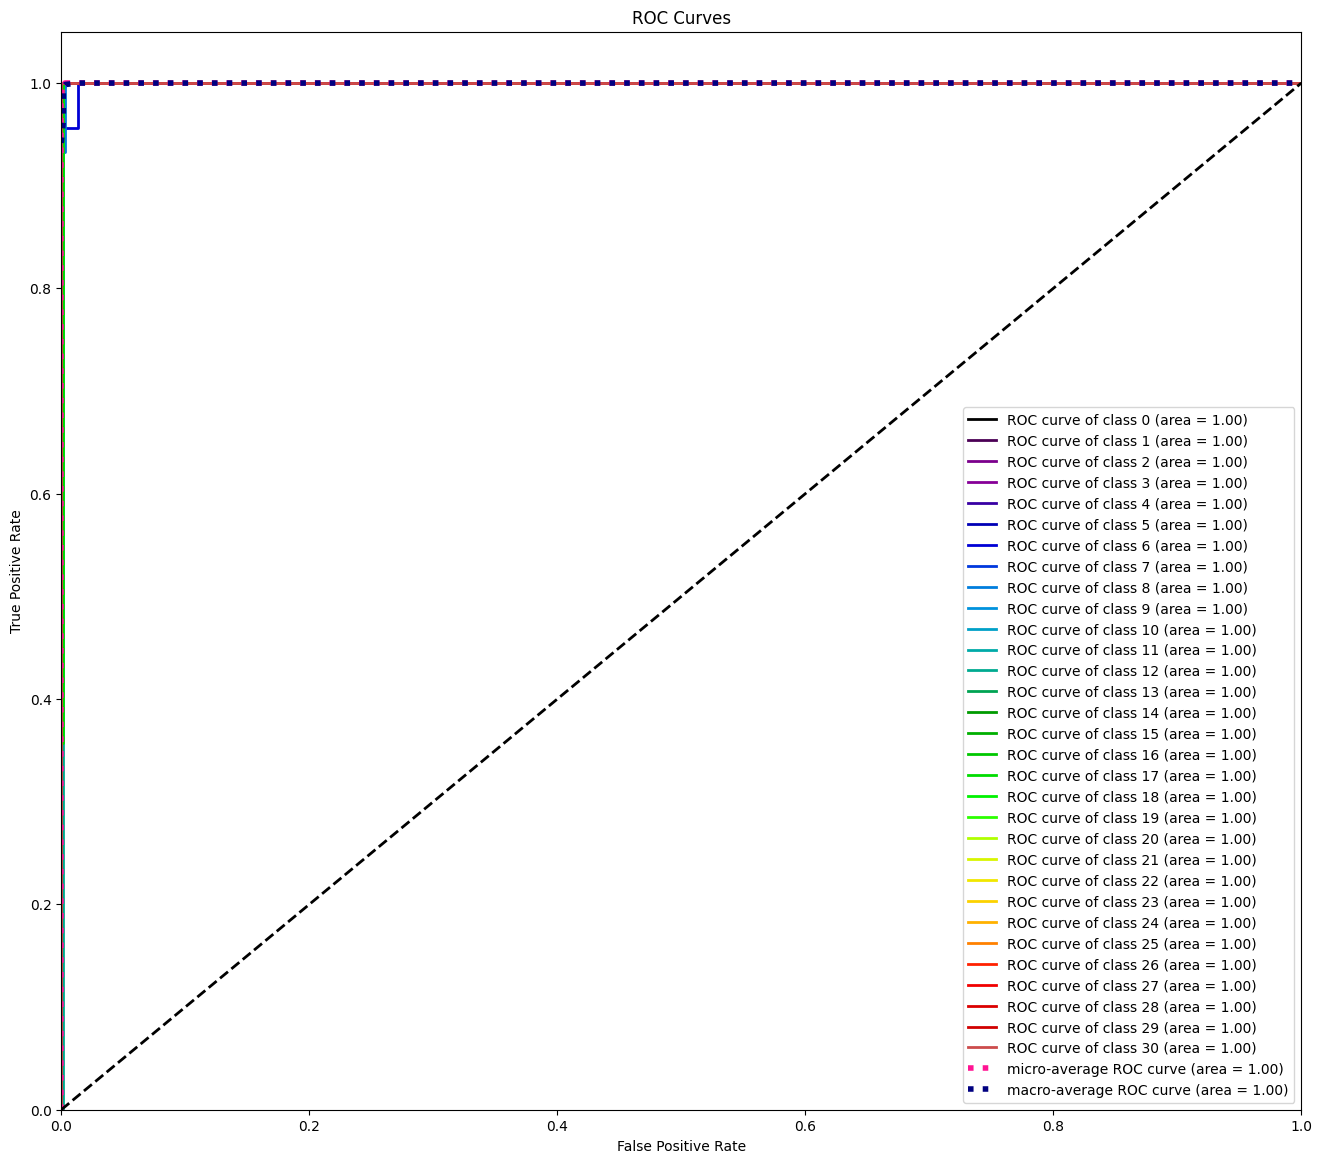

In [40]:
plot_roc(
    test_labels, 
    test_probs, 
    figsize=(16, 14), title_fontsize='large'
);

# **Performance Analysis**

**Probabilities and Predictions**

In [41]:
results_df = pd.DataFrame({
    'image_path'       : test_ds.paths,
    'label'            : test_ds.labels,
    'label_encoded'    : test_labels,
    'model_prediction' : test_preds,
    'model_probability': [test_probs[_][pred] for _, pred in zip(range(len(test_probs)), test_preds)]
})

pd.set_option('display.max_colwidth', None)
results_df

,image_path,label,label_encoded,model_prediction,model_probability
0,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Al/Al_14.jpg,Al,1,1,0.891211
1,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Jeem/Jeem_114.jpg,Jeem,10,10,0.739380
2,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Beh/Beh_32.jpeg,Beh,3,3,0.867004
3,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Dad/Dad_209.jpg,Dad,4,4,0.905077
4,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Ghain/Ghain_57.jpeg,Ghain,7,7,0.880725
...,...,...,...,...,...
624,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Laa/Laa_211.jpg,Laa,13,13,0.896892
625,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Sheen/Sheen_255.jpg,Sheen,21,21,0.899789
626,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Teh_Marbuta/Teh_Marbuta_252.jpg,Teh_Marbuta,24,24,0.888624
627,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Heh/Heh_192.jpg,Heh,9,9,0.894461


In [42]:
def view_multiple_predictions(df, classes, sample_loader, count=10, color_map='rgb', title=None, fig_size=(14, 10)):
    rows = count//5
    if count%5 > 0:
        rows +=1
    
    idx = random.sample(df.index.to_list(), count)
    
    fig = plt.figure(figsize=fig_size)
    if title != None:
        fig.suptitle(title, fontsize=30)
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    
    # Setup useful dictionaries
    label_set = {k: v for k, v in enumerate(classes)}
    color_set = {False: 'red', True: 'darkgreen'}
    
    for column, _ in enumerate(idx):
        # Predict label
        img = sample_loader(df.image_path[_]).permute(1, 2, 0)
        
        # Validate prediction correctness
        correct_prediction = (df.model_prediction[_] == df.label_encoded[_])
        
        # Create subplot and assign title
        ax = plt.subplot(rows, 5, column+1)
        ax.set_title(
            f'Actual Label: {df.label[_]}', 
            pad=20, 
            fontsize=14,
            color=color_set[correct_prediction]
        )
        
        # Plot image
        if color_map=='rgb':
            ax.imshow(img)
        else:
            ax.imshow(img, cmap=color_map)
        
        # Plot prediction  & probability
        txt = f'Prediction: {label_set[df.model_prediction[_]]}\nProbability: {(100 * df.model_probability[_]):.2f}%'
        plt.xlabel(txt, fontsize=14, color=color_set[correct_prediction])
        
    return

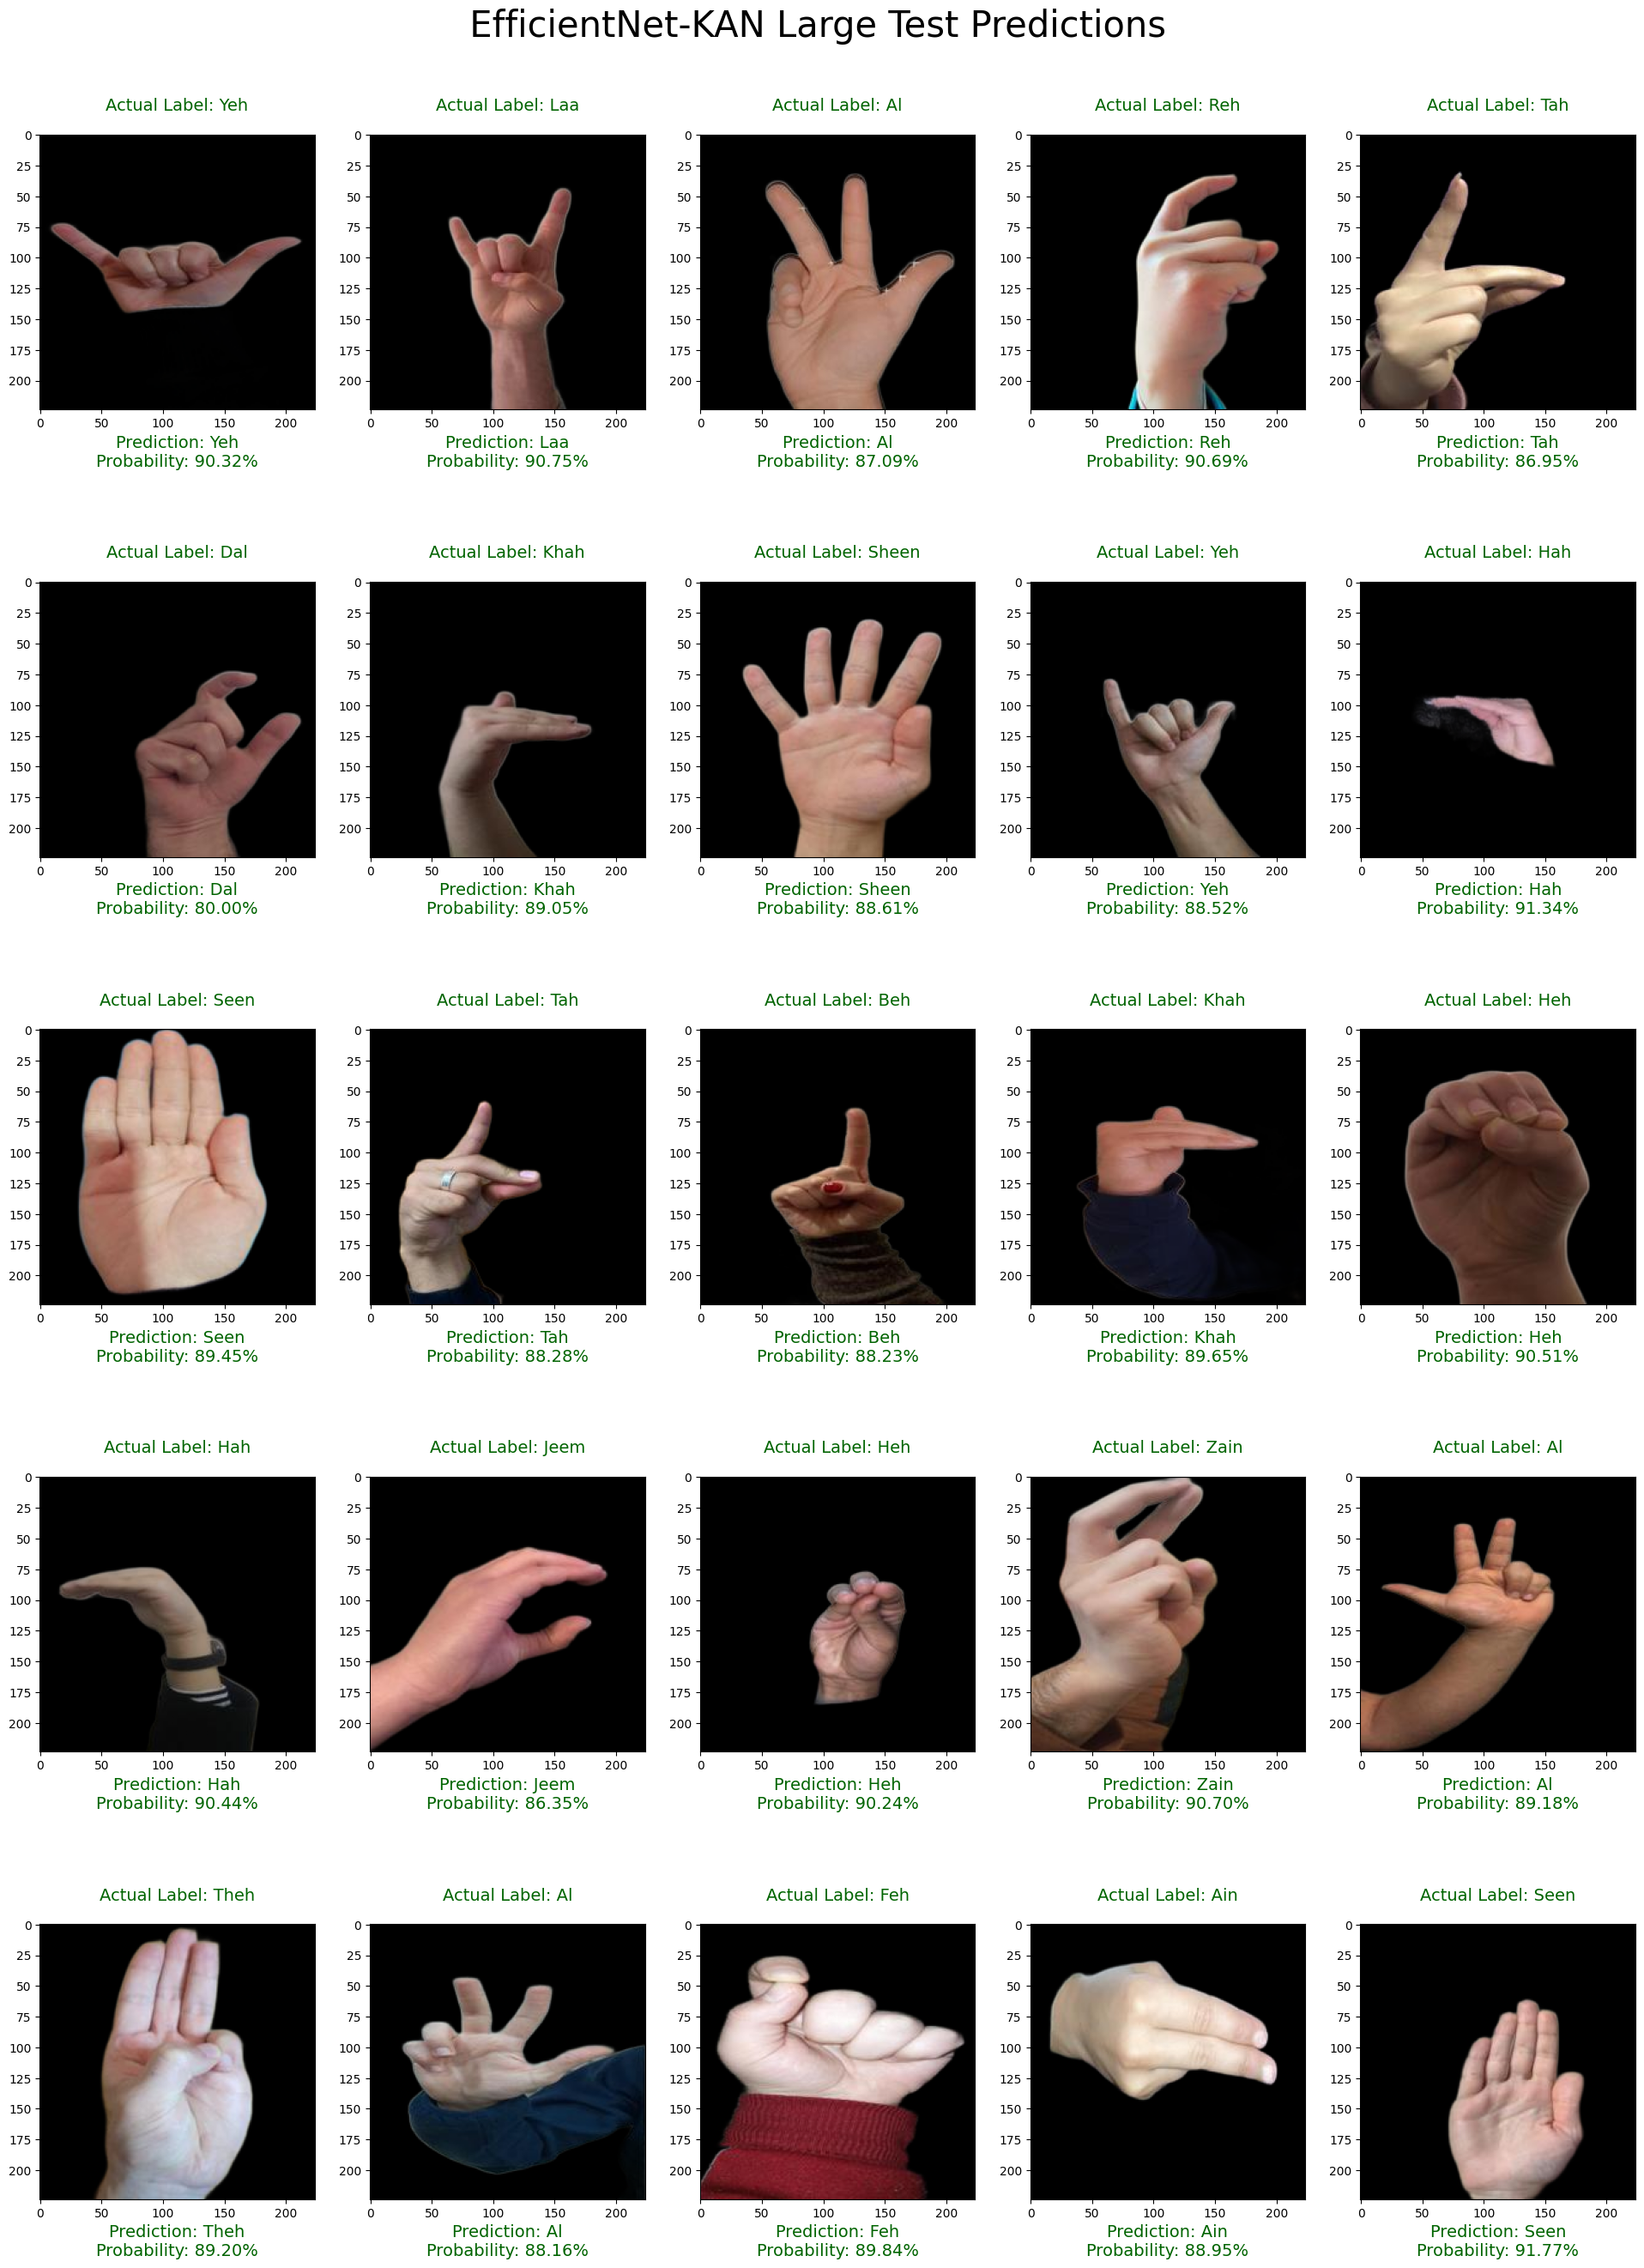

In [43]:
view_multiple_predictions(
    results_df,
    test_ds.classes,
    load, 
    count=25, 
    color_map='rgb', 
    title=' EfficientNet-KAN Large Test Predictions',
    fig_size=(24, 30)
)

**Incorrect Predictions**

In [44]:
# Query incorrect predictions
query_df = results_df[
    results_df['label_encoded'] != results_df['model_prediction']
].reset_index(drop=True)

# View incorrect predictions
query_df

,image_path,label,label_encoded,model_prediction,model_probability
0,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Qaf/Qaf_165.jpg,Qaf,17,9,0.880093
1,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Feh/Feh_114.jpg,Feh,6,17,0.899439
2,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Hah/Hah_137.jpg,Hah,8,12,0.928389
3,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Thal/thal_198.jpg,Thal,25,10,0.701591
4,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Qaf/Qaf_140.jpg,Qaf,17,6,0.644209
5,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Sad/Sad_107.jpg,Sad,19,6,0.584928
6,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Qaf/Qaf_109.jpg,Qaf,17,9,0.696813


In [45]:
# Save incorrect predictions info in csv file
query_df.to_csv('EfficientNet-KAN incorrect_predictions.csv', index=True)

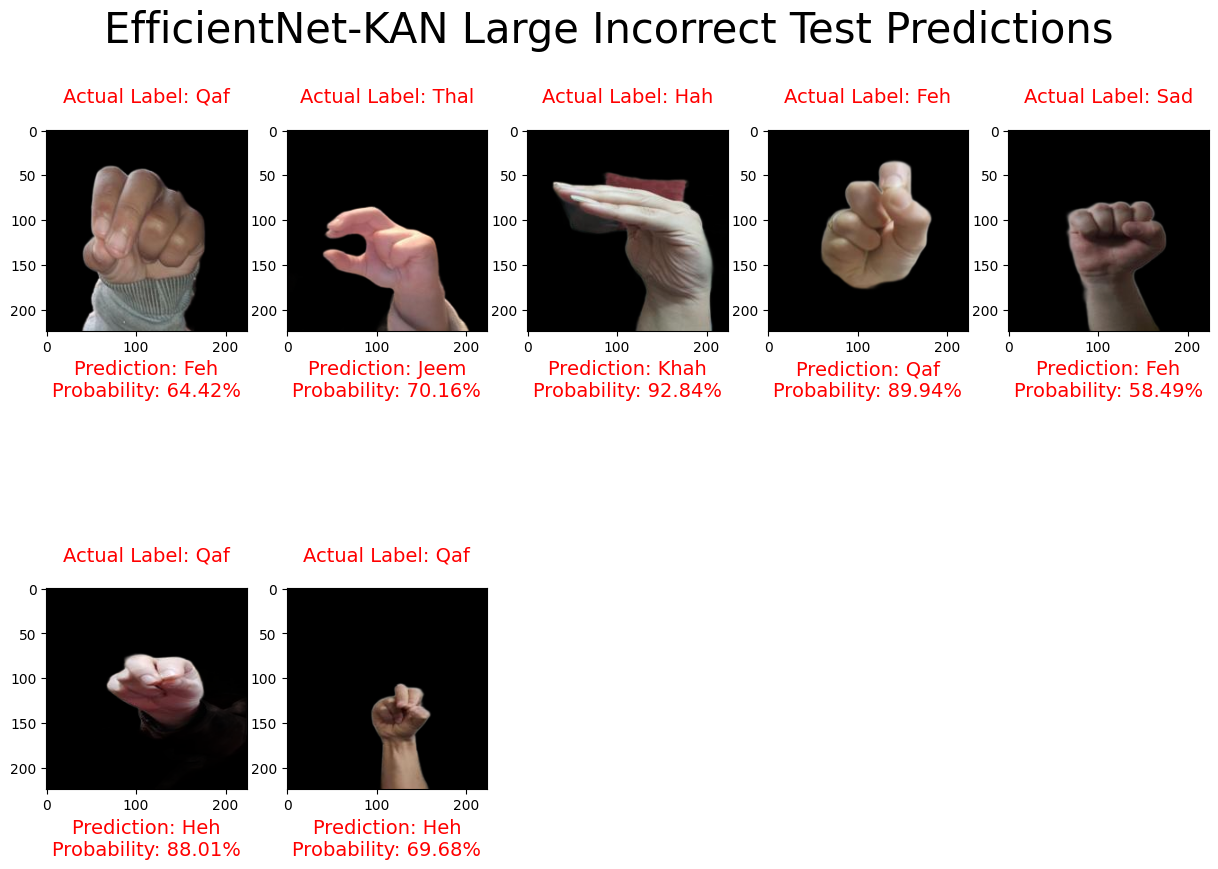

In [55]:
view_multiple_predictions(
    query_df,
    test_ds.classes,
    load, 
    count=7, 
    color_map='rgb', 
    title='EfficientNet-KAN Large Incorrect Test Predictions',
    fig_size=(15, 10)
)

# **GradCAM**

In [47]:
#git clone
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-xcoxjrkm
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-xcoxjrkm
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit fd4b5c863fbfc06b23d2d396413e08831c2c2ecf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=41821 sha256=171aa82407fd323b12f2cf717dd35eddc15c6b9c2d573db9ec9f721d9d4d010b
  Stored in directory: /tmp/pip-ephem-wheel-cache-583gicra/wheels/23/11/66/71a38b0c29ba4ec5f62105a2145278613855bc9c94eecf630d
Successfully built grad-cam


In [48]:
#imports
import copy
import torchvision
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [49]:
target_layers = [model.model.blocks[-1][-1].conv_pwl]

In [50]:
pd.set_option('display.max_colwidth', None)
sorted_df = results_df.sort_values(by="model_probability", ascending=False)
sorted_df.head(10)
#sorted_df['image_path']

,image_path,label,label_encoded,model_prediction,model_probability
594,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Theh/Theh_149.jpeg,Theh,26,26,0.942984
207,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Feh/Feh_10.jpg,Feh,6,6,0.940188
623,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Lam/Lam_241.jpg,Lam,14,14,0.934667
489,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Dal/Dal_214.jpg,Dal,5,5,0.933238
582,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Meem/Meem_33.jpeg,Meem,15,15,0.932624
532,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Tah/Tah_68.jpg,Tah,22,22,0.930858
179,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Meem/Meem_50.jpg,Meem,15,15,0.929300
396,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Hah/Hah_137.jpg,Hah,8,12,0.928389
224,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Meem/Meem_120.jpg,Meem,15,15,0.928340
111,/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Hah/Hah_60.jpg,Hah,8,8,0.926052


In [51]:
sorted_df.to_csv('EfficientNet-KAN sorted probability.csv', index=True)

In [69]:
paths = "/kaggle/input/arsl-no-background-v2/ARSL-No-BackGround-V2/Feh/Feh_10.jpg"

rgb_img = Image.open(paths).convert('RGB')
# Max min normalization
rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))
# Create an input tensor image for your model
input_tensor = torchvision.transforms.functional.to_tensor(rgb_img).unsqueeze(0).float()
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

grayscale_cam = cam(input_tensor=input_tensor)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

**GradCAM Visualization**

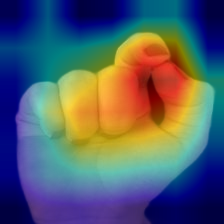

In [70]:
Image.fromarray(visualization, 'RGB')

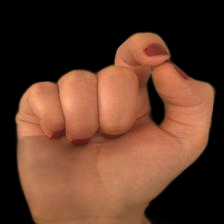

In [71]:
Image.open(paths).convert('RGB')